<a href="https://colab.research.google.com/github/innovateDotAI/ReadyToUseModels/blob/main/GNN_NodeClassification_Dataset%3DCORA_Algo%3DGAT__v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

v1 : This notebook details the steps related to Node classification using Graph attention network algorithm. 

v2 : 1. Customize Training, Validation and Test size of data added
Application area: Social media mining
  2. Added Attention algorithm details

**Expectation setting from this demo**

This demo has been created to show the Graph neural network algorithm capabilities and understanding how we can exploite the GNN capabilties to solve various problem related to Non-Euclidian space problem

#Library used

In [ ]:
!pip install --upgrade scipy

In [ ]:
!pip install spektral

In [ ]:
import spektral
import keras
import matplotlib.pyplot as plt
import numpy as np
from random import sample 

# Dataset

**About dataset**

In this notebook we are using [CORA](https://relational.fit.cvut.cz/dataset/CORA) citation dataset.Node attributes are bag-of-words vectors representing the most common words in the text document associated to each node.Two papers are connected if either one cites the other. Labels represent the subject area of the paper.

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

**Load dataset**

In [ ]:
cora_data=spektral.datasets.citation.Citation('cora',random_split=True, normalize_x=True)

Pre-processing node features


/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


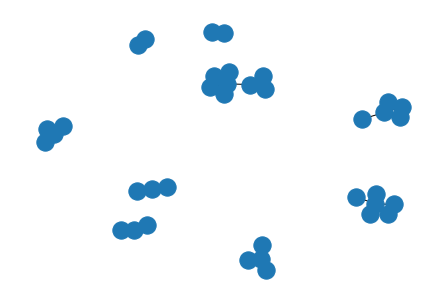

In [ ]:
# Draw the graph
edge_array = (np.argwhere(cora_data[0].a))
edge_tup = tuple(map(tuple, edge_array))
e10 = edge_tup[1:30] # Number of edges used to draw the graph
import networkx as nx
G = nx.Graph()
G.add_edges_from(e10)
nx.draw(G)

**Problem statement**

In the cora dataset we need to lable the unknown labled of nodes.

**Training, Validation and Test Dataset creation**

In [ ]:
class TrainValTestdataset:
  def __init__(self,node,TrRatio,ValRatio,ClassLable):
    self.node = node # Total number of node in the graph
    self.TrRatio = TrRatio 
    self.ValRatio = ValRatio
    self.ClassLabel = ClassLable
  def creatDataset(self):
    self.node_tr = list()
    self.node_va = list()
    self.node_te = list()
    for lable in range(self.ClassLabel.shape[1]):
      #print('Lable=',lable)
      self.Node = list(np.where(self.ClassLabel[:,int(lable)] == 1)[0]) # Lable wise generate index value
      #print('self.Node lablewise',len(self.Node))
      #print('self.TrSize:',self.TrSize)
      self.TrSize = int(len(self.Node)*self.TrRatio/100)
      #print('self.TrSize=',self.TrSize)
      self.TrNode = sample(self.Node,self.TrSize) # Create Random sampel of nodes used in training
      #print('self.TrNode',self.TrNode)
      self.Node = set(self.Node) - set(self.TrNode)
      #print('len(self.Node)',len(self.Node))
      #print('self.ValRatio',self.ValRatio)
      self.ValSize = int(len(self.Node)*self.ValRatio/100)
      #print('self.ValSize',self.ValSize)
      self.ValNode = sample(self.Node,self.ValSize)
      self.TestNode = list(set(self.Node) - set(self.ValNode))
      self.node_tr.extend(self.TrNode)
      self.node_va.extend(self.ValNode)
      self.node_te.extend(self.TestNode)
      #print('self.node_tr=',self.node_va)

    self.TrNodeSet = np.zeros(self.node, dtype = int)
    self.ValNodeSet = np.zeros(self.node, dtype = int)
    self.TestNodeSet = np.zeros(self.node, dtype = int)
    for i in self.node_tr:
      self.TrNodeSet[i] = 1
      self.TrNodeSetWt = self.TrNodeSet / np.count_nonzero(self.TrNodeSet)
    for i in self.node_va:
      self.ValNodeSet[i] = 1
      self.ValNodeSetWt = self.ValNodeSet / np.count_nonzero(self.ValNodeSet)
    for i in self.node_te:
      self.TestNodeSet[i] = 1
      self.TestNodeSetWt = self.TestNodeSet / np.count_nonzero(self.TestNodeSet)
    return self.TrNodeSetWt,self.ValNodeSetWt,self.TestNodeSetWt

In [ ]:
# Train , validation and Test dataset
GNode = cora_data[0].a.shape[0] # Number of nodes in the graph
TrSize = 40 # Percentage of nodes
ValSize = 5 # Percentage of nodes
ClassLable = cora_data[0].y
p1 = TrainValTestdataset(GNode,TrSize,ValSize,ClassLable)
wt_set = p1.creatDataset()
weights_tr, weights_va, weights_te = wt_set[0],wt_set[1],wt_set[2]
loader_tr = spektral.data.loaders.SingleLoader(cora_data, sample_weights=weights_tr) # Training dataset
loader_va = spektral.data.loaders.SingleLoader(cora_data, sample_weights=weights_va) # Validation dataset
loader_te = spektral.data.loaders.SingleLoader(cora_data, sample_weights=weights_te) # Test dataset


**Exploratory analysis of dataset**

In [ ]:
# Let's understand the adjacency matrix
print('Understand Graph Data:',cora_data[0])
# Let's understand labels
print('Class lables for nodes:',cora_data[0].y.shape)
# Node featureSet shape( Node X Featuressize)
print("Node featureset Shape", cora_data[0].x.shape)

# Edge featureSet
print("Edge featureset Shape", cora_data[0].e)
# Adjacency  matrix 
print("Adjacency matrix Shape", cora_data[0].a.shape[0])

Understand Graph Data: Graph(n_nodes=2708, n_node_features=1433, n_edge_features=None, n_labels=7)
Class lables for nodes: (2708, 7)
Node featureset Shape (2708, 1433)
Edge featureset Shape None
Adjacency matrix Shape 2708


# Algorithm design and execution

**Algorithm Literature surave**

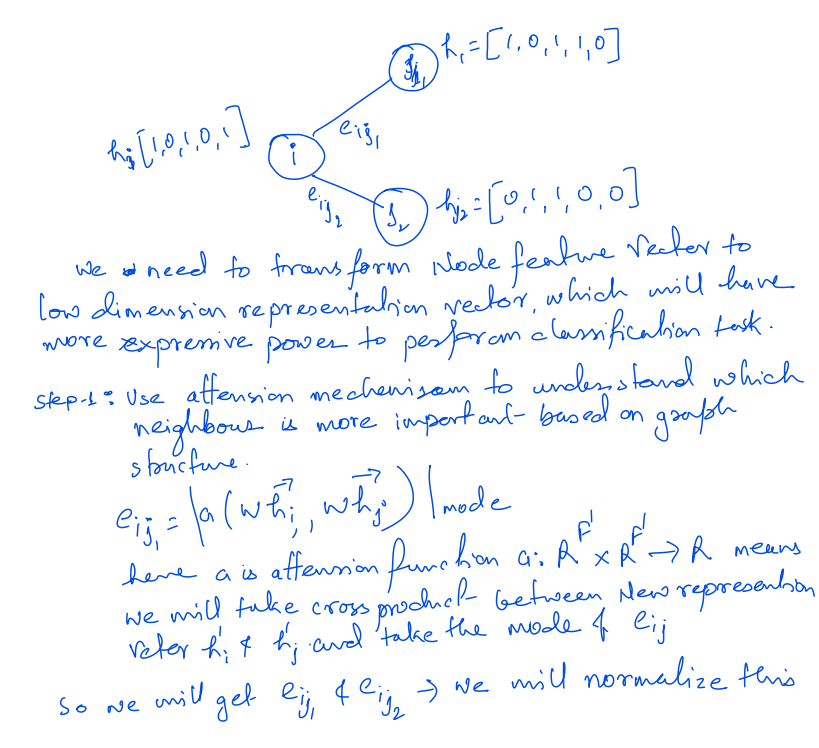

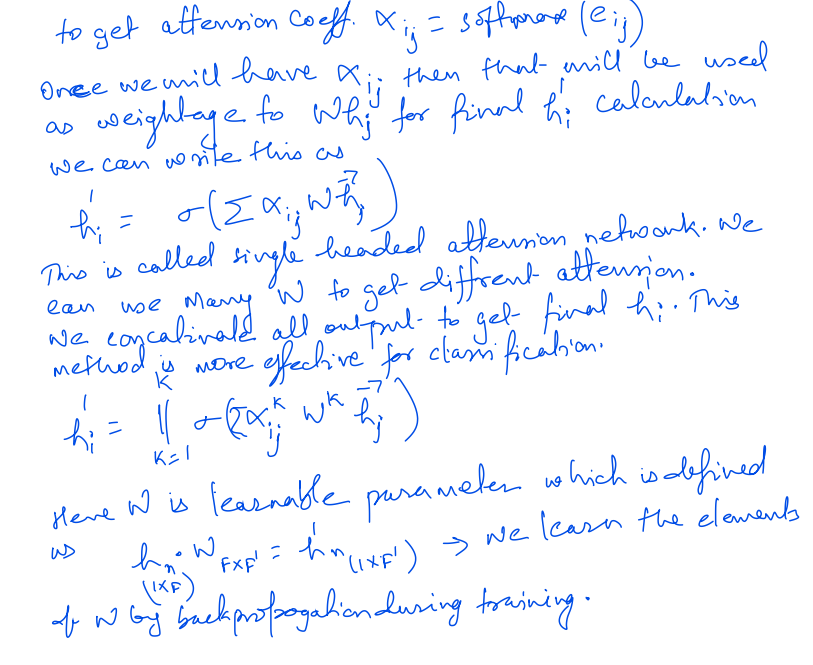

High level understadnig of Attention layer algorithm
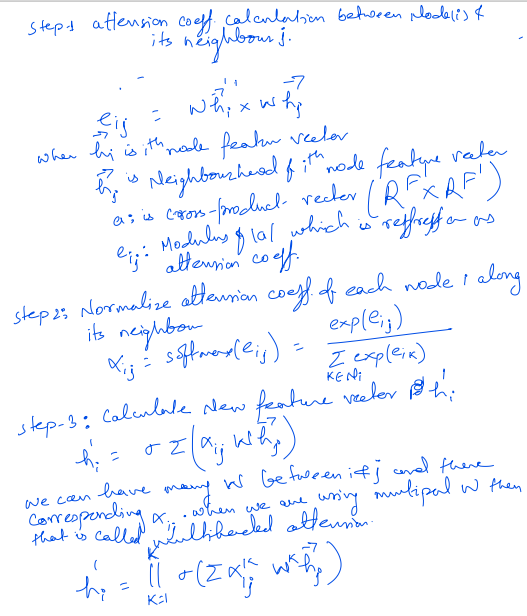

For details refer [Graph attention network](https://arxiv.org/abs/1710.10903)

**Build and execute Model**

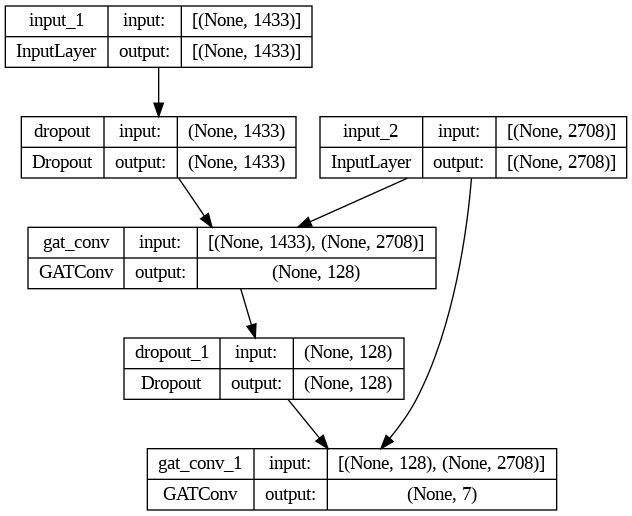

In [ ]:
# Build the Model
# Inputs
in_x = keras.Input(shape=(cora_data[0].x.shape[1],)) # Takes one features at a time
in_a = keras.Input(shape=(cora_data[0].a.shape[0],), sparse=True) # Takes one row at a time
# Add dropout on features (but not adjacency matrix)
dropout_1 = keras.layers.Dropout(.1)(in_x)
# Add GAT layer
gat_layer_1 = spektral.layers.GATConv(
    channels=16,
    attn_heads=8  ,
    concat_heads=True,
    dropout_rate=.05,
    activation='selu',
    kernel_initializer='lecun_normal'
)([dropout_1, in_a]) # Output of Layer is channels*attn_head if concat_heads = True; else output = channels
# Add dropout
dropout_2 = keras.layers.Dropout(.1)(gat_layer_1)
# Final GAT layer
gat_out = spektral.layers.GATConv(
    channels=cora_data[0].n_labels,
    attn_heads=8,
    concat_heads=False,
    dropout_rate=.05,
    activation='softmax'
)([dropout_2, in_a])
# Enclose the layers in the model
model = keras.Model(inputs=[in_x, in_a], outputs=gat_out)
import tensorflow as tf
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
cora_data[0].n_labels

7

In [ ]:
# Complie the Model
# Set some params
LR = 5e-3 # 5e-3  # Learning rate
EPOCHS = 10000  # Number of training epochs
PATIENCE = 30  # Patience for early stopping
# Compile the model
optimizer = keras.optimizers.Adam(lr=LR)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1433)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 gat_conv (GATConv)             (None, 128)          183808      ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Train the Model
callbacks = [
    keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=PATIENCE//2, min_lr=5e-6, factor=.9)
]

history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/10000
1/1 [==============================] - 4s 4s/step - loss: 1.9459 - acc: 0.1360 - val_loss: 1.9403 - val_acc: 0.3117 - lr: 0.0050
Epoch 2/10000
1/1 [==============================] - 0s 216ms/step - loss: 1.9405 - acc: 0.3043 - val_loss: 1.9315 - val_acc: 0.3117 - lr: 0.0050
Epoch 3/10000
1/1 [==============================] - 0s 236ms/step - loss: 1.9320 - acc: 0.3025 - val_loss: 1.9189 - val_acc: 0.3117 - lr: 0.0050
Epoch 4/10000
1/1 [==============================] - 0s 214ms/step - loss: 1.9200 - acc: 0.3025 - val_loss: 1.9026 - val_acc: 0.3117 - lr: 0.0050
Epoch 5/10000
1/1 [==============================] - 0s 206ms/step - loss: 1.9044 - acc: 0.3025 - val_loss: 1.8828 - val_acc: 0.3117 - lr: 0.0050
Epoch 6/10000
1/1 [==============================] - 0s 218ms/step - loss: 1.8857 - acc: 0.3025 - val_loss: 1.8601 - val_acc: 0.3117 - lr: 0.0050
Epoch 7/10000
1/1 [==============================] - 0s 207ms/step - loss: 1.8639 - acc: 0.3025 - val_loss: 1.8355 - val_acc: 0

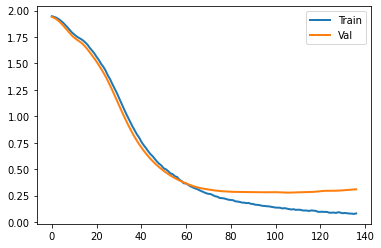

In [ ]:
# Plot the training efficiecncy
plt.plot(history.history['loss'], label='Train', lw=2)
plt.plot(history.history['val_loss'], label='Val', lw=2)
plt.legend()
plt.show()

# Result Assesment and Interpretation

In [ ]:
# Evaluate model
print("Evaluating model.")
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

Evaluating model.
1/1 [==============================] - 0s 58ms/step - loss: 0.4537 - acc: 0.8626
Done.
Test loss: 0.453665167093277
Test accuracy: 0.8625807166099548


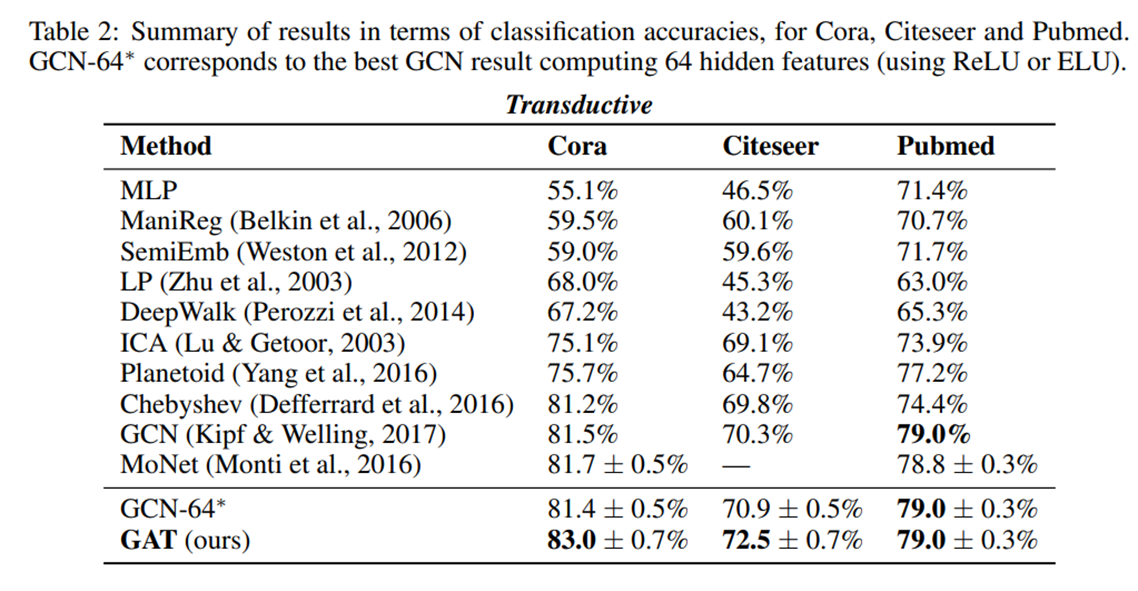